100%|██████████| 50/50 [1:22:44<00:00, 99.29s/it, Best fitness: 0.80] 


Best solution parameters: [1.008e+03 1.421e+00 5.600e+01 3.000e+00 1.000e+00]
Best fitness (accuracy): 0.7976999878883362


/opt/homebrew/Caskroom/miniforge/base/envs/mai/lib/python3.12/site-packages/pygad/visualize/plot.py:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


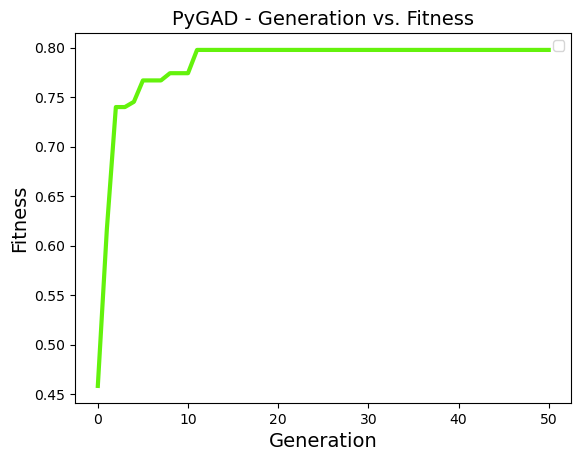

In [11]:
import numpy as np
import pygad            # Genetic Algorithm
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


#Use FashionMNIST dataset. The task is a lot more challenging than MNIST.
train_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
torch.manual_seed(42)
np.random.seed(42)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

X_train = train_data.data.numpy()
y_train = train_data.targets.numpy()
X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()


# Convert numpy to torch tensors and move to GPU if available:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test,  dtype=torch.long).to(device)

# 2) Simple PyTorch model:
class SimpleNet(nn.Module):
    def __init__(self, hidden_units=64, activation=0,hidden_layers=1):
        super(SimpleNet, self).__init__()
        self.activation = [nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU()][activation]
        # Create an initial input layer
        self.layers = nn.ModuleList([nn.Linear(28*28, hidden_units)])
        # Create additional hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
        # Final output layer
        self.out = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        return self.out(x)

# 3) Training + evaluation in a function:
def train_and_evaluate(hidden_units, learning_rate, epochs, activation, hidden_layers):
    model = SimpleNet(hidden_units, activation, hidden_layers).to(device)
    criterion = nn.CrossEntropyLoss() # loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Train:
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()
    # Evaluate:
    with torch.no_grad(): # no need to track gradients for validation
        preds = model(X_test_t).argmax(dim=1)
        accuracy = (preds == y_test_t).float().mean().item()
    return accuracy

def fitness_func(instance, solution, sol_idx):
    # parse genome and evaluate fitness
    hidden_units = int(solution[0])
    learning_rate = float(solution[1])
    epochs = int(solution[2])
    activation = int(solution[3])
    hidden_layers = int(solution[4])
    accuracy = train_and_evaluate(hidden_units, learning_rate, epochs, activation, hidden_layers)
    return accuracy  # maximizing accuracy

# 4) Setup gene space and run GA:
gene_space = [
    range(16, 1025, 16),              # hidden_units
    np.arange(0.001, 10, 0.01),    # learning_rate
    np.arange(1,100,1),                 # epochs
    np.arange(0, 4, 1),                   # activation
    np.arange(1, 5, 1)                 # hidden layers
]

def on_generation_progress(ga):
    pbar.update(1)
    best_solution, best_solution_fitness, _ = ga_instance.best_solution()
    pbar.set_postfix_str(f"Best fitness: {best_solution_fitness:.2f}")
    # save plot of best result to file
    
    
    # plot the fitness progress
    #plot = ga_instance.plot_fitness(save_dir=f"plots/ga{ga_instance.generations_completed}", show=False)

num_generations = 50
with tqdm.tqdm(total=num_generations) as pbar:
  ga_instance = pygad.GA(
      num_generations=num_generations,
      num_parents_mating=3, # number of parents
      fitness_func=fitness_func,
      sol_per_pop=7, # population
      num_genes=len(gene_space),
      gene_space=gene_space,
      mutation_percent_genes=25, # 25% of genes will be mutated
      on_generation=on_generation_progress,
      random_seed=42
  )
  ga_instance.run()
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print("Best solution parameters:", best_solution)
print("Best fitness (accuracy):", best_solution_fitness)
plot = ga_instance.plot_fitness(save_dir=f"plots/ga{ga_instance.generations_completed}")